In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch


In [9]:
file_path =pd.read_excel(r"C:\Users\Yaveh\Desktop\Mosiño final\E314--DeathsMX (1).xlsx", engine='openpyxl' )
df = pd.DataFrame(file_path)

In [10]:
df.rename(columns={df.columns[0]: 'Mes'}, inplace=True)
df = df[df['Mes'] != 'Total']

In [12]:
df_long = df.melt(id_vars=['Mes'], var_name='Anio', value_name='Defunciones')
meses_dict = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df_long['Mes_Num'] = df_long['Mes'].map(meses_dict)

In [13]:
df_long['Fecha'] = pd.to_datetime(dict(year=df_long['Anio'], month=df_long['Mes_Num'], day=1))
if df_long['Defunciones'].dtype == 'object':
    df_long['Defunciones'] = df_long['Defunciones'].astype(str).str.replace(',', '').astype(float)
df_final = df_long.sort_values('Fecha').set_index('Fecha')
serie_tiempo = df_final['Defunciones']


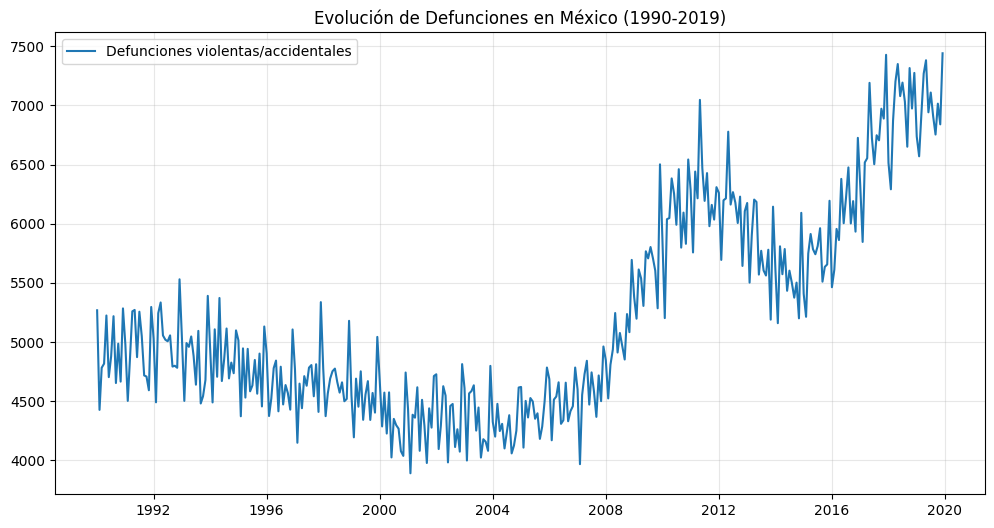

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(serie_tiempo, label='Defunciones violentas/accidentales')
plt.title('Evolución de Defunciones en México (1990-2019)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:

df_final.to_csv('defunciones_limpio_long.csv')

#df_final.to_excel('defunciones_limpio_long.xlsx')

print("¡Archivos guardados exitosamente en tu carpeta de trabajo!")

¡Archivos guardados exitosamente en tu carpeta de trabajo!


Procesamiento arriba, abajo es trabajo 

In [7]:
df = pd.read_csv(r'C:\Users\Yaveh\Desktop\Mosiño final\Defunciones_largo.csv')
df['Fecha'] = pd.to_datetime(dict(year=df['Anio'], month=df['Mes_Num'], day=1))

In [8]:
df = df.set_index('Fecha').sort_index()
y = df['Defunciones']

In [12]:
df['dummy_2007']=0
df.loc['2007-01-01':,'dummy_2007']=1
exog_data = df['dummy_2007']


In [13]:
modelo_sarimax = SARIMAX(y, 
                         exog=exog_data,
                         order=(1, 1, 1),              # (p,d,q)
                         seasonal_order=(0, 1, 1, 12), # (P,D,Q,s)
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultados = modelo_sarimax.fit(disp=False)

print(resultados.summary())

c:\Users\Yaveh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Yaveh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        Defunciones   No. Observations:                  360
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2210.093
Date:                            Thu, 04 Dec 2025   AIC                           4430.185
Time:                                    14:54:49   BIC                           4449.226
Sample:                                01-01-1990   HQIC                          4437.778
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dummy_2007   -78.0329    219.457     -0.356      0.722    -508.160     352.094
ar.L1         -0.1863      0.076   

In [15]:
residuos = resultados.resid

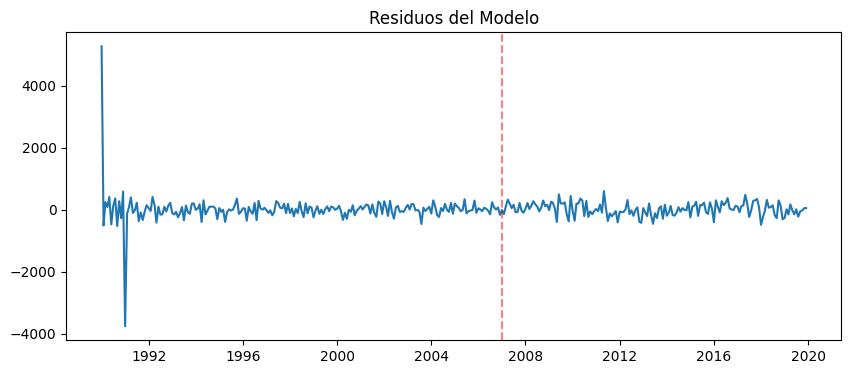

In [17]:
plt.figure(figsize=(10,4))
plt.plot(residuos)
plt.title("Residuos del Modelo")
plt.axvline(pd.to_datetime('2007-01-01'), color='r', linestyle='--', alpha=0.5)
plt.show()

In [18]:
print("\n>>> AJUSTANDO MODELO GARCH DE VOLATILIDAD... <<<")
garch_model = arch_model(residuos, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary())


>>> AJUSTANDO MODELO GARCH DE VOLATILIDAD... <<<
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2436.08
Distribution:                  Normal   AIC:                           4880.15
Method:            Maximum Likelihood   BIC:                           4895.69
                                        No. Observations:                  360
Date:                Thu, Dec 04 2025   Df Residuals:                      359
Time:                        14:58:04   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5.907

c:\Users\Yaveh\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.543e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [23]:
residuos_scaled = residuos / 100

print("\n>>> AJUSTANDO MODELO GARCH (ESCALADO CORRECTO) <<<")

garch_model_fixed = arch_model(residuos_scaled, vol='Garch', p=1, q=1)
garch_fit_fixed = garch_model_fixed.fit(disp='off')

print(garch_fit_fixed.summary())


>>> AJUSTANDO MODELO GARCH (ESCALADO CORRECTO) <<<
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -778.214
Distribution:                  Normal   AIC:                           1564.43
Method:            Maximum Likelihood   BIC:                           1579.97
                                        No. Observations:                  360
Date:                Thu, Dec 04 2025   Df Residuals:                      359
Time:                        16:12:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0

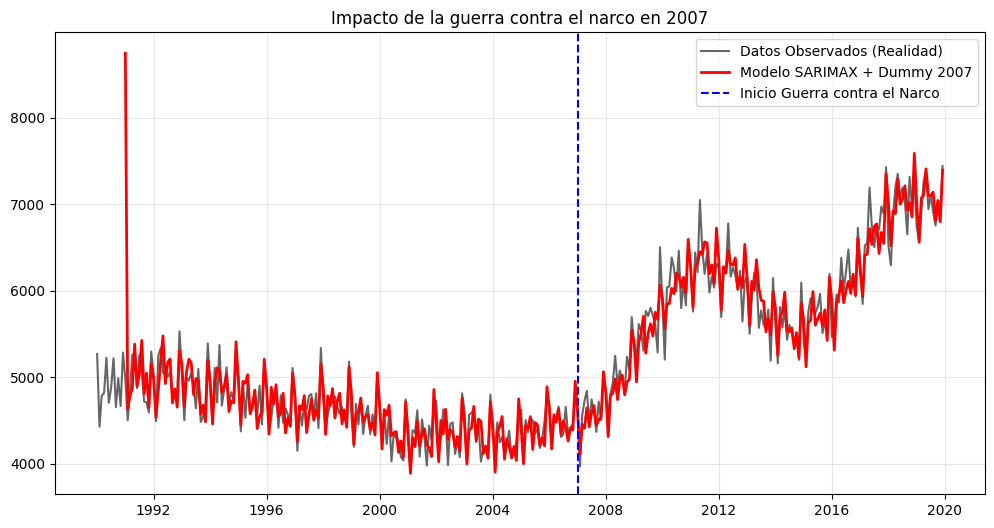

In [19]:
prediccion = resultados.get_prediction(start=pd.to_datetime('1991-01-01'))
pred_mean = prediccion.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(y, label='Datos Observados (Realidad)', color='black', alpha=0.6)
plt.plot(pred_mean, label='Modelo SARIMAX + Dummy 2007', color='red', linewidth=2)

plt.title('Impacto de la guerra contra el narco en 2007')
plt.axvline(pd.to_datetime('2007-01-01'), color='blue', linestyle='--', label='Inicio Guerra contra el Narco')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

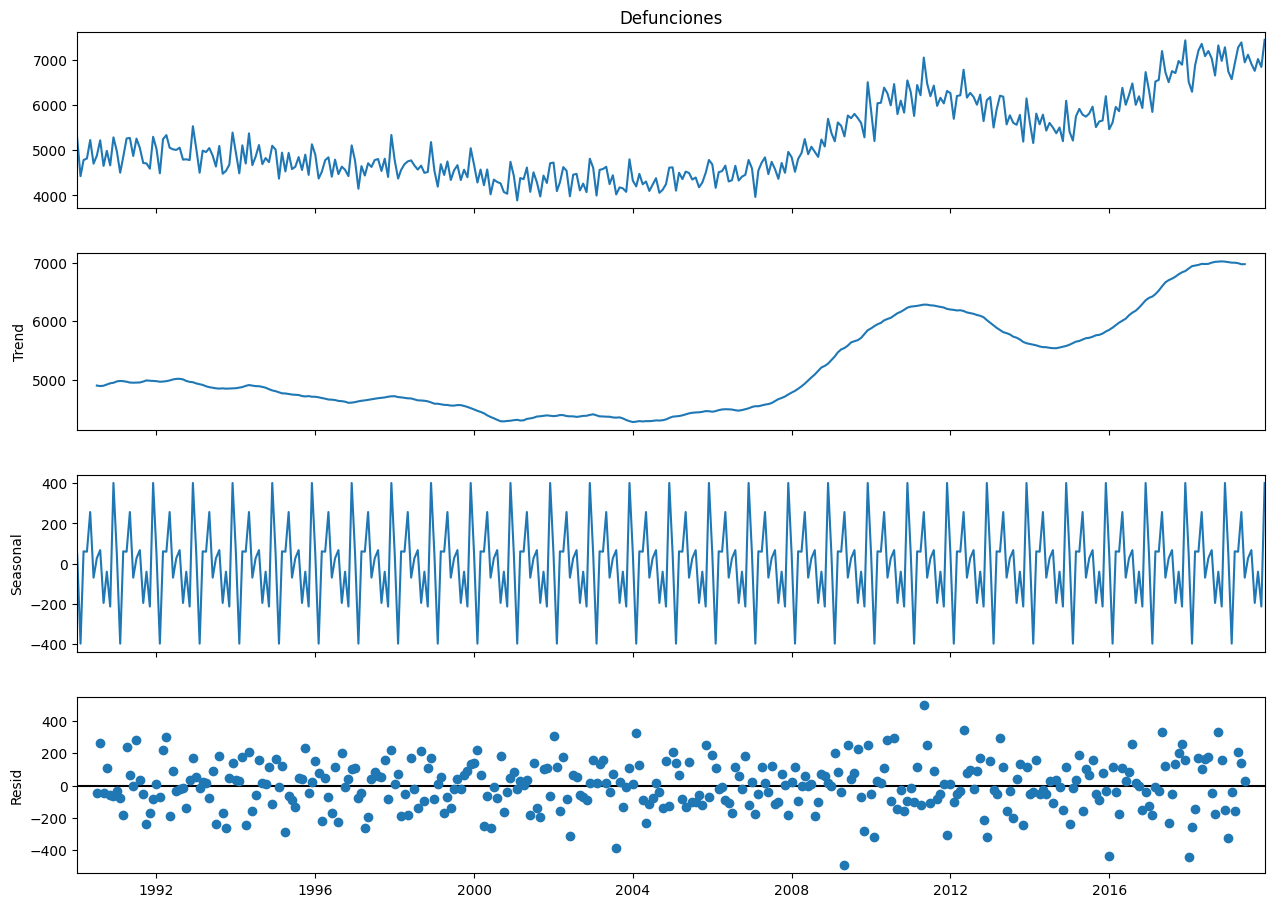

In [22]:
descomposicion = seasonal_decompose(df['Defunciones'], model='additive', period=12)

fig = descomposicion.plot()
fig.set_size_inches(14, 10)

In [ ]:
residuos = resultados.resid

lm_stat, lm_pval, f_stat, f_pval = het_arch(residuos)

print(f"P-value del test ARCH-LM: {lm_pval:.4f}")

if lm_pval < 0.05:
    print("RESULTADO: Se rechaza la hipótesis nula.")
    print("HAY Heteroscedasticidad (efecto ARCH).")
    print("CONCLUSIÓN: ¡Se justifica y es necesario usar el modelo GARCH!")
else:
    print("No hay heteroscedasticidad.")

P-value del test ARCH-LM: 1.0000
No hay heteroscedasticidad.


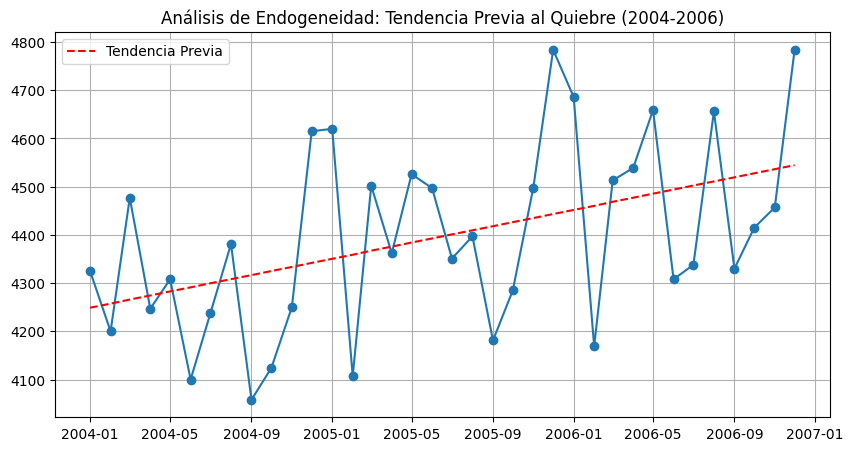

Pendiente de la tendencia previa: 8.45


In [ ]:
zoom = df.loc['2004-01-01':'2006-12-01']

plt.figure(figsize=(10, 5))
plt.plot(zoom['Defunciones'], marker='o')
plt.title('Análisis de Endogeneidad: Tendencia Previa al Quiebre (2004-2006)')

z = np.polyfit(range(len(zoom)), zoom['Defunciones'], 1)
p = np.poly1d(z)
plt.plot(zoom.index, p(range(len(zoom))), "r--", label='Tendencia Previa')
plt.legend()
plt.grid(True)
plt.show()

pendiente = z[0]
print(f"Pendiente de la tendencia previa: {pendiente:.2f}")